In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cxroots

In [2]:
%matplotlib inline

In [3]:
import xwglib as tmm

In [4]:
energy = 14.41

materials = {
    'Pt' : tmm.XRLMaterial(formula='Pt', color='grey', density=21.45),
    'Ta' : tmm.XRLMaterial(formula='Ta', color='green', density=16.6),
    'B4C' : tmm.XRLMaterial(formula='B4C',color='yellow', density=2.52),
    'C' : tmm.XRLMaterial(formula='C', color='black', density=3.52),
    'Fe' : tmm.XRLMaterial(formula='Fe', color='red', density=7.87),
    'Air' : tmm.ConstMaterial(name='Air', color='white', index=1.0)
}

In [5]:
inner_layers = (
    tmm.Layer(materials['Pt'], 3),
    tmm.Layer(materials['B4C'], 10),
    tmm.Layer(materials['Fe'], 1),
    tmm.Layer(materials['B4C'], 15),
)
layerstack = tmm.LayerStack(materials['Air'], 
                        inner_layers, 
                        materials['Pt'] )

In [6]:
m = tmm.Model(*layerstack.get_parameters(energy=energy), method='conformal')
s = tmm.Modefinder(m)

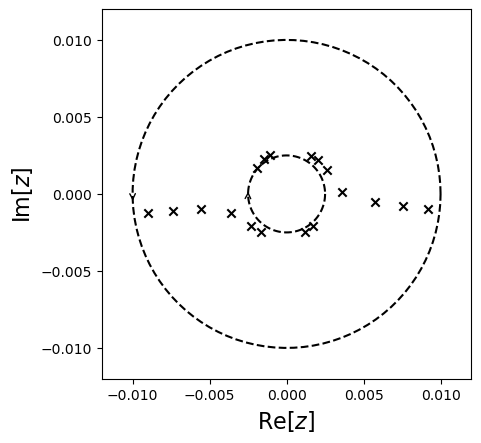

In [7]:
contour = cxroots.Annulus(center=0, radii=(2.5e-3, 10e-3))

result, rootresult = s.find_modes(contour)
rootresult.show()


In [8]:
print(result.indices_guided - 1)
print(result.indices_leaky_double - 1)
print(result.indices_other - 1)

[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --]
[-- -- -- -- -- -- -- -- -- -- -- -- --
 (-2.5253982210093895e-05+4.267864149342263e-06j) --
 (-3.6855993527762365e-05+7.157647152212645e-06j) --
 (-5.0104153668018014e-05+1.0365885187490501e-05j)]
[(-3.5686958334002483e-06+2.6090325395090735e-08j) --
 (-4.051130473858855e-06-3.062702273715993e-08j)
 (-4.0963726958276325e-06+8.880355685521134e-08j)
 (-6.1043858915477145e-06-2.771625596298285e-08j) --
 (-7.728967121978236e-06-3.080208999328201e-07j)
 (-7.91226838381398e-06+2.451815534528755e-07j)
 (-1.0728170656171265e-05-3.7130888573489805e-08j) --
 (-1.5115950351085594e-05-1.348830060346634e-06j) --
 (-2.379510913497196e-05-3.654307829532525e-06j) --
 (-3.5192184521637415e-05-6.378051562742738e-06j) --
 (-4.8141987706307177e-05-9.518040465249504e-06j) --]


In [9]:
# no guided modes
# the interesting solutions are the negative leaky ones

In [10]:
# resonance widths in physical energy

print(f'bandwidth: {result.indices_leaky_neg.compressed()[0].imag * energy:.2e} keV')

bandwidth: 1.20e-06 keV


In [11]:
xmin = 1 - 5e-5
xmax = 1

In [12]:
rad_neg, rad_pos = s.radiation_modes(np.linspace(xmin, xmax, 100))

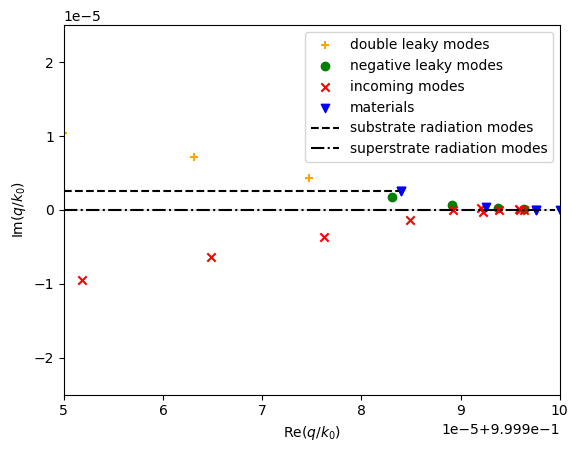

In [14]:
fig, ax = plt.subplots()
#ax.scatter(result.indices_guided.real, result.indices_guided.imag, color='green', label='guided modes')
ax.scatter(result.indices_leaky_double.real, result.indices_leaky_double.imag, marker='+', color='orange', label='double leaky modes')
ax.scatter(result.indices_leaky_neg.real, result.indices_leaky_neg.imag, marker='o', color='green', label='negative leaky modes')
ax.scatter(result.indices_other.real, result.indices_other.imag, marker='x', color='red', label='incoming modes')

ax.scatter(s.model.n.real, s.model.n.imag, marker='v', color='blue', label='materials')
#ax.scatter(n_clad.real, n_clad.imag)
ax.plot(rad_pos.real, rad_pos.imag, ls='--', color='black', label='substrate radiation modes')
ax.plot(rad_neg.real, rad_neg.imag, ls='-.', color='black', label='superstrate radiation modes')

ax.axhline(0, color='black', alpha=0.1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(-2.5e-5, 2.5e-5)

#ax.grid()
ax.set_xlabel(r'$\mathrm{Re}(q/k_0)$')
ax.set_ylabel(r'$\mathrm{Im}(q/k_0)$')
ax.legend()
#fig.savefig('modes.png')

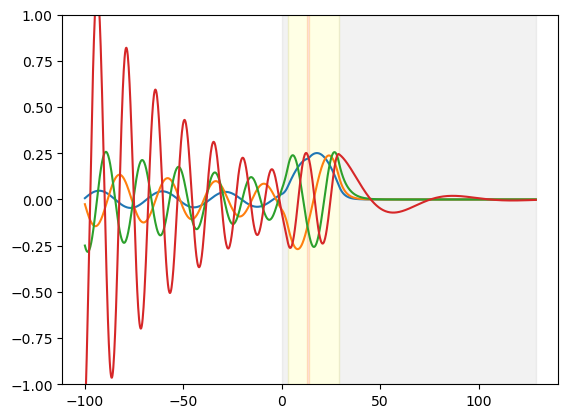

In [15]:
margin = 100

xxx = np.linspace(0-margin, layerstack.get_thickness()+margin, 1000)


fig, ax = plt.subplots()
ax.set_ylim(-1,1)
for u in (result.modes_leaky_neg.compressed()):

    profile0 = s.solution_pos_te(u, normalized=True)
    ax.plot(xxx, np.real(profile0(xxx)))

layerstack.plot_layers(ax, infinity=margin)

## modefinder in fourier coordinates

In [16]:
m2 = tmm.Model(*layerstack.get_parameters(energy=energy), method='fourier', branch=tmm.BranchCut.vertical)
s2 = tmm.Modefinder(m2)

In [18]:
# split the given rectangle into a set of rectangle contours that exclude the vertical branch cuts
# still very crude

branchpoints = (m2.n_neg, m2.n_pos)
x_range = (1-5.5e-5,1)
y_range = (-1e-5, 3e-5)
contours = tmm.get_contours(branchpoints, x_range=x_range, y_range=y_range, eps=1e-7)


In [19]:
results, rootresults = zip(*[s2.find_modes(c, polarization='TE') for c in contours])

result2 = results[0] + results[1]

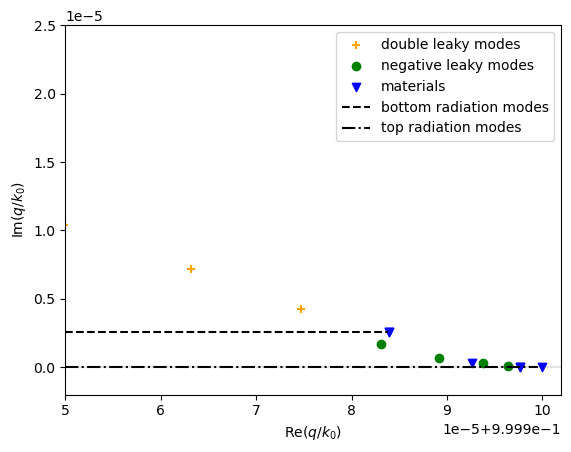

In [20]:
fig, ax = plt.subplots()
#ax.scatter(result2.indices_guided.real, result2.indices_guided.imag, color='green', label='guided modes')
ax.scatter(result2.indices_leaky_double.real, result2.indices_leaky_double.imag, marker='+', color='orange', label='double leaky modes')
ax.scatter(result2.indices_leaky_neg.real, result2.indices_leaky_neg.imag, marker='o', color='green', label='negative leaky modes')
#ax.scatter(result2.indices_other.real, result2.indices_other.imag, marker='x', color='red', label='incoming modes')

ax.scatter(s.model.n.real, s.model.n.imag, marker='v', color='blue', label='materials')
#ax.scatter(n_clad.real, n_clad.imag)
ax.plot(rad_pos.real, rad_pos.imag, ls='--', color='black', label='bottom radiation modes')
ax.plot(rad_neg.real, rad_neg.imag, ls='-.', color='black', label='top radiation modes')

ax.axhline(0, color='black', alpha=0.1)

ax.set_xlim(xmin, xmax+0.2e-5)
ax.set_ylim(-0.2e-5, 2.5e-5)

#ax.grid()
ax.set_xlabel(r'$\mathrm{Re}(q/k_0)$')
ax.set_ylabel(r'$\mathrm{Im}(q/k_0)$')
ax.legend()
#fig.savefig('modes.png')

(-1.0, 1.0)

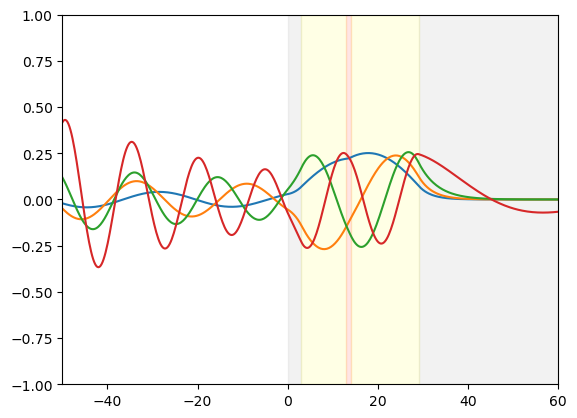

In [21]:
margin = 100
xxx = np.linspace(0-margin, layerstack.get_thickness()+margin, 1000)


fig, ax = plt.subplots()
layerstack.plot_layers(ax, infinity=margin)

for r_ in np.flip(np.sort(result2.indices_leaky_neg.compressed())):

    profile0 = s2.solution_pos_te(r_, normalized=True, force_resonant=True)
    ax.plot(xxx, np.real(profile0(xxx)))
ax.set_xlim(-50,60)
ax.set_ylim(-1,1)
